In [2]:
!python3 -m pip install torch torchvision torchaudio scikit-learn opencv-python unet segmentation-models-pytorch

Using cpu device
Epoch--[1/300], Loss: 0.3544715940952301
Epoch--[2/300], Loss: 0.2770114541053772
Epoch--[3/300], Loss: 0.23503491282463074
Epoch--[4/300], Loss: 0.21543340384960175
Epoch--[5/300], Loss: 0.20409628748893738
Epoch--[6/300], Loss: 0.18740224838256836
Epoch--[7/300], Loss: 0.17969322204589844
Epoch--[8/300], Loss: 0.17473959922790527
Epoch--[9/300], Loss: 0.16851361095905304
Epoch--[10/300], Loss: 0.17050611972808838
Epoch--[11/300], Loss: 0.16362373530864716
Epoch--[12/300], Loss: 0.16019417345523834
Epoch--[13/300], Loss: 0.15496788918972015
Epoch--[14/300], Loss: 0.1541627049446106
Epoch--[15/300], Loss: 0.1532011330127716
Epoch--[16/300], Loss: 0.1490517407655716
Epoch--[17/300], Loss: 0.15041352808475494
Epoch--[18/300], Loss: 0.1513121873140335
Epoch--[19/300], Loss: 0.14696791768074036
Epoch--[20/300], Loss: 0.14465656876564026
Epoch--[21/300], Loss: 0.14465968310832977
Epoch--[22/300], Loss: 0.14645341038703918
Epoch--[23/300], Loss: 0.1413925290107727
Epoch--[24

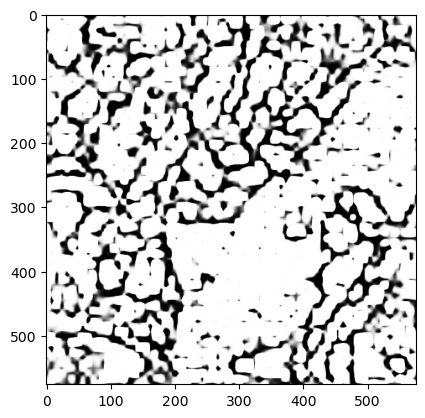

In [4]:
"""
Created on Aug 04 2025

@author: vigo
"""
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

import numpy as np 
import cv2 as cv

import re
import glob

from unet import UNet
from segmentation_models_pytorch import UnetPlusPlus, PSPNet

torch.cuda.empty_cache()

NET_INPUT_SIZE = (576, 576)
NET_OUTPUT_SIZE = (576, 576)

def Normalize(img):
    return np.array(img/255.0, dtype=np.float32)

def Shape_Process(img):
    if img.shape > NET_INPUT_SIZE:
        img = cv.resize(img, NET_INPUT_SIZE, interpolation = cv.INTER_CUBIC)   # image reduction
        
    elif img.shape < NET_INPUT_SIZE:
        if img.shape[0] % 2:
            img = cv.resize(img, img.shape[0] // 2, interpolation = cv.INTER_CUBIC)
        padd = int((NET_INPUT_SIZE[0] - img.shape[0]) / 2)
        img = cv.copyMakeBorder(img, padd, padd, padd, padd, cv.BORDER_REFLECT_101)
        
    return img

def Center_Crop(img):
    img = Shape_Process(img)
    crop_yx = (int((img.shape[0] - NET_OUTPUT_SIZE[0]) / 2), int((img.shape[1] - NET_OUTPUT_SIZE[1]) / 2))
    img = img[crop_yx[0]: crop_yx[0] + NET_OUTPUT_SIZE[0], crop_yx[1]: crop_yx[1] + NET_OUTPUT_SIZE[1]]
    
    return img

def Numerical_Sort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def Read_Images_Test(folder_path, image_names):
    images = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        img = cv.imread(filename, flags = cv.IMREAD_GRAYSCALE)
        img = Shape_Process(img)
        images.append(Normalize(img))
    
    images = np.asarray(images, dtype=np.float32)
    images = images[:, :, :, np.newaxis, np.newaxis]    # format => [N, H, W, C1, C2]
    return images

def Read_Images_Train(folder_path, image_names):
    images = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        img = cv.imread(filename, flags = cv.IMREAD_GRAYSCALE)
        img = Shape_Process(img)
        images.append(Normalize(img))
    
    images = np.asarray(images, dtype=np.float32)
    images = images[:, :, :, np.newaxis]    # format => [N, H, W, C]
    return images

def Read_Images_GTruth(folder_path, image_names):
    labels = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        mask = cv.imread(filename, flags = cv.IMREAD_GRAYSCALE)
        mask = Center_Crop(mask)
        mask = Normalize(mask)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        labels.append(mask)
    
    labels = np.asarray(labels, dtype=np.float32)
    labels = labels[:, :, :, np.newaxis]    # format => [N, H, W, C]
    return labels

def Matplotlib_Imshow(img):
    npimg = img.cpu().detach().numpy()
    npimg = (npimg * 255.0).astype("int")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

#%% dataset load and preprocessing

drive_path = "./data" 

test_images_path = drive_path + "/test/*.tif"

train_gtruth_path = drive_path + "/train/labels/*.tif"
train_images_path = drive_path + "/train/images/*.tif"

test_images = []
image_names = []
train_gtruth = []
train_images = []
test_images = Read_Images_Test(test_images_path, image_names)
train_images = Read_Images_Train(train_images_path, image_names)    
train_gtruth = Read_Images_GTruth(train_gtruth_path, image_names)

#%% Create data loaders.

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# pytorch input format => [N, H, W, C1] -> [N, C1, H, W]
train_tensor = torch.from_numpy(train_images).transpose_(2 , 3).transpose_(1 , 2).float().to(device)
train_gtruth_tensor = torch.from_numpy(train_gtruth).transpose_(2 , 3).transpose_(1 , 2).float().to(device)
# pytorch input format => [N, H, W, C1, C2] -> [N, C1, C2, H, W]
test_tensor = torch.from_numpy(test_images).transpose_(1 , 3).transpose_(2 , 4).float().to(device)

batch_size = 2
train_dl = DataLoader(train_tensor, batch_size=batch_size, shuffle=False)
train_gtruth_dl = DataLoader(train_gtruth_tensor, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_tensor, batch_size = len(test_images), shuffle=False)
test_iter = next(iter(test_dl))

#%% create model
def get_pspnet_model():
    return PSPNet(
    encoder_name="resnet34",        # backbone
    encoder_weights=None,           # or "imagenet" if RGB
    in_channels=1,                  # you are loading grayscale images
    classes=1                       # binary segmentation
    )
    
model = get_pspnet_model().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 300

#%% train
for e in range(n_epochs):
    for i in range(len(train_dl)):
        train_iter = next(iter(train_dl))
        train_gtruth_iter = next(iter(train_gtruth_dl))
        optim.zero_grad()
        prediction = model(train_iter)
        loss = F.binary_cross_entropy_with_logits(prediction, train_gtruth_iter)
        loss.backward()
        optim.step()
    print (f'Epoch--[{e+1}/{n_epochs}], Loss: {loss.item()}')

print('Finished Training')

#%% predict 
test_img_index = 0
with torch.no_grad():
    test_prediction_logits = model(test_iter[test_img_index])
    test_prediction = torch.sigmoid(test_prediction_logits)

# show images
img_grid = make_grid(test_prediction)
Matplotlib_Imshow(img_grid)

#%% model save
torch.save(model.state_dict(), "./model.pth")
print("Saved PyTorch Model State to model.pth")

#%% model load
model_test = get_pspnet_model().to(device)
model_test.load_state_dict(torch.load("./model.pth"))

with torch.no_grad():
    test_prediction_logits = model_test(test_iter[0])
    test_prediction = torch.sigmoid(test_prediction_logits)
    
img_grid = make_grid(test_prediction)

# show images
Matplotlib_Imshow(img_grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7234..37451].


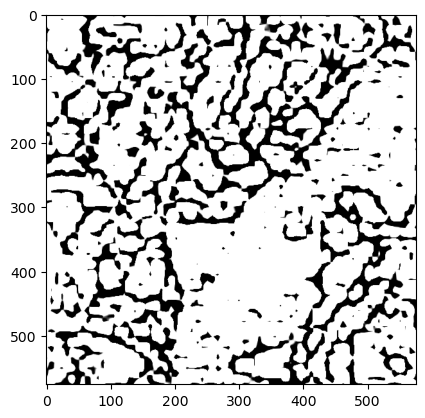

In [12]:
#%% model load
model_test = get_pspnet_model().to(device)
model_test.load_state_dict(torch.load("./model.pth"))

test_prediction = model_test(test_iter[0])
img_grid = make_grid(test_prediction)

# show images
Matplotlib_Imshow(img_grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6997..50412].


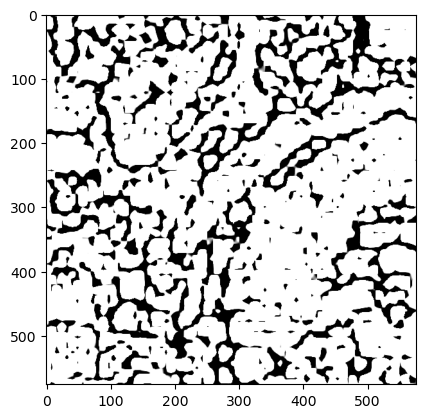

In [6]:
test_prediction = model_test(test_iter[7])
img_grid = make_grid(test_prediction)

# show images
Matplotlib_Imshow(img_grid)

In [9]:
print(loss.item())

0.11863050609827042


In [10]:
def metrics(preds, targets, threshold=0.5):
    if preds.max() > 1 or preds.min() < 0:
        preds = torch.sigmoid(preds)

    preds_bin = (preds > threshold).float()
    targets_bin = (targets > 0.5).float()

    preds_flat = preds_bin.view(-1)
    targets_flat = targets_bin.view(-1)

    TP = (preds_flat * targets_flat).sum().item()
    FP = (preds_flat * (1 - targets_flat)).sum().item()
    FN = ((1 - preds_flat) * targets_flat).sum().item()
    TN = ((1 - preds_flat) * (1 - targets_flat)).sum().item()

    # Metrics
    epsilon = 1e-7  # to avoid division by zero
    jaccard = TP / (TP + FP + FN + epsilon)
    f1_score = (2 * TP) / (2 * TP + FP + FN + epsilon)
    recall = TP / (TP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)

    return {
        "Jaccard": jaccard,
        "F1 Score": f1_score,
        "Recall": recall,
        "Precision": precision,
        "Accuracy": accuracy
    }

model_test.eval()
with torch.no_grad():
    train_preds = model(train_tensor)
    metrics = metrics(train_preds, train_gtruth_tensor)
    print(metrics)

{'Jaccard': 0.7895915910433197, 'F1 Score': 0.8824265770973959, 'Recall': 0.8941290362859429, 'Precision': 0.8710264866203344, 'Accuracy': 0.8128865057548786}


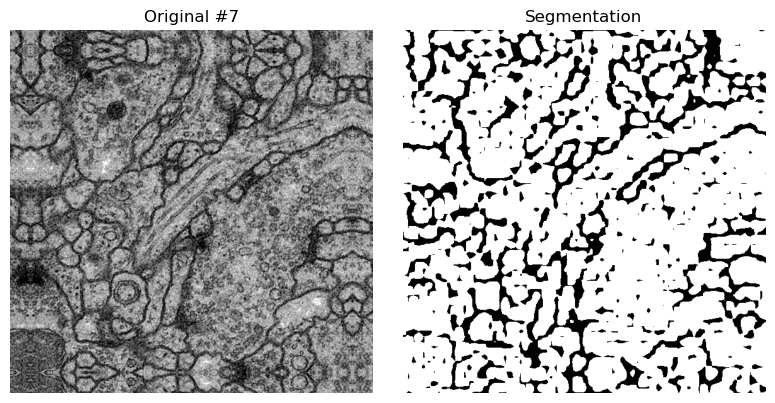

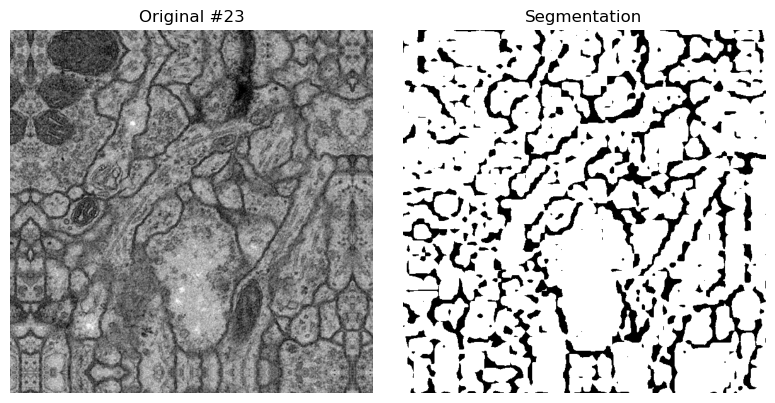

In [17]:
import torch, numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def _find_path(ds, idx):
    # Try common places ImageFolder/custom datasets store paths
    cand_attrs = ["samples","imgs","image_paths","images","files","paths","items"]
    for a in cand_attrs:
        if hasattr(ds, a):
            seq = getattr(ds, a)
            try:
                item = seq[idx]
            except Exception:
                continue
            # (path, label) or just path
            if isinstance(item, (list, tuple)) and item and isinstance(item[0], str):
                return item[0]
            if isinstance(item, str):
                return item
    # Optional custom getter
    if hasattr(ds, "get_path"):
        try: return ds.get_path(idx)
        except Exception: pass
    return None

def show_orig_and_mask(idx):
    # ---- get transformed tensor & predict ----
    batch = test_iter[idx]
    img_t = batch[0] if isinstance(batch, (list, tuple)) else batch   # CHW tensor
    x = img_t.to(device)
    if x.ndim == 3: x = x.unsqueeze(0)

    with torch.no_grad():
        logits = model_test(x)  # [B,C,H,W] or [B,1,H,W]

    if logits.shape[1] == 1:
        prob = torch.sigmoid(logits)[0, 0]              # [H,W]
        mask = (prob > 0.5).to(torch.uint8)
    else:
        mask = torch.softmax(logits, dim=1).argmax(1)[0].to(torch.uint8)

    # ---- fetch the ORIGINAL on-disk image in pure B/W ----
    raw = None
    if hasattr(test_iter, "dataset"):
        p = _find_path(test_iter.dataset, idx)
        if p is not None:
            raw = np.array(Image.open(p).convert("L"))   # HxW uint8

    # Fallback: force strict grayscale from the tensor (no color)
    if raw is None:
        vis = img_t.detach().cpu().float()
        if vis.ndim == 3:
            if vis.shape[0] == 1:
                vis = vis[0]
            else:
                vis = vis.mean(0)                        # average channels => gray
        else:
            vis = vis.squeeze()
        vmin, vmax = float(vis.min()), float(vis.max())
        raw = ((vis - vmin) / (vmax - vmin + 1e-8) * 255).clip(0, 255).byte().numpy()

    # Resize mask to match raw size if needed (nearest to preserve labels)
    mask_np = mask.cpu().numpy()
    if mask_np.shape != raw.shape:
        mask_np = np.array(Image.fromarray(mask_np).resize((raw.shape[1], raw.shape[0]), Image.NEAREST))

    # ---- plot ----
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(raw, cmap="gray", vmin=0, vmax=255); ax[0].set_title(f"Original #{idx}"); ax[0].axis("off")
    ax[1].imshow(mask_np, cmap="gray");              ax[1].set_title("Segmentation");     ax[1].axis("off")
    plt.tight_layout(); plt.show()

# Show for 7 and 23
for i in [7, 23]:
    show_orig_and_mask(i)
